In [31]:

# Mismas librerias
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Concatenate, LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Input, Model
# Para cambiar la particion de datos
from sklearn.model_selection import train_test_split
import numpy as np



# Para el análisis de palabras individuales
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd


import matplotlib.pyplot as plt



In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

In [15]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}


# Analizes if a word is positive or negative (from -1 to 1)
analyzer = SentimentIntensityAnalyzer()

print(type(X_train))


<class 'numpy.ndarray'>


In [16]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

print(type(X[0]))

<class 'list'>


In [22]:

def estimate_sentiment_per_word(reverse_word_index: dict, analyzer: SentimentIntensityAnalyzer)-> dict:

    token_sentiment = {token: analyzer.polarity_scores(word).get('compound') for token, word in reverse_word_index.items()}

    return token_sentiment

def count_good_and_bad_words(tokenized_word: list, token_sentiment: dict, min_score: int = 0.2)-> tuple:
    if min_score>1 or min_score<-1:
        min_score = 0.2

    good_words_count = 0
    total_words = len(tokenized_word)

    for token_word in tokenized_word:
        sentiment = token_sentiment.get(token_word)
        if sentiment>min_score:
            good_words_count += 1

    return good_words_count, total_words-good_words_count


def average_score_sentiment(tokenized_word: list, token_sentiment: dict):
    average = 0
    for token_word in tokenized_word:
        average += token_sentiment.get(token_word)
    
    return average/(len(tokenized_word))

def extend_word_features(X: np.ndarray, token_sentiment: dict) -> np.ndarray:
    extended_samples = []
    
    for sample in X:
        tokenized_word = sample
        
        good_words_count, bad_words_count = count_good_and_bad_words(tokenized_word, token_sentiment)
        
        avg_score = average_score_sentiment(tokenized_word, token_sentiment)
        
        # Extending the sample with the new features
        extended_sample = [tokenized_word, [good_words_count, bad_words_count, avg_score]]
        
        extended_samples.append(extended_sample)
    
    return np.array(extended_samples, dtype=object)




In [10]:
token_sentiment = estimate_sentiment_per_word(reverse_word_index, analyzer)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = extend_word_features(X_train, token_sentiment)
X_test = extend_word_features(X_test, token_sentiment)

# For padding
X_train_sequences = sequence.pad_sequences(np.array([sample[0] for sample in X_train], dtype=object), maxlen=80)
X_test_sequences = sequence.pad_sequences(np.array([sample[0] for sample in X_test], dtype=object), maxlen=80)

# For feeding to the model
X_train_new_features = np.array([sample[1] for sample in X_train])
X_test_new_features = np.array([sample[1] for sample in X_test])




In [26]:

sequence_input = Input(shape=(80,), dtype='int32', name='sequence_input') 
scalar_input = Input(shape=(3,), dtype='float32', name='scalar_input')  


embedded_sequences = Embedding(input_dim=50000, output_dim=128)(sequence_input)
lstm_out = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)


dense_out = Dense(32, activation='relu')(scalar_input)


concatenated = Concatenate()([lstm_out, dense_out])


output = Dense(1, activation='sigmoid')(concatenated)


modelo = Model(inputs=[sequence_input, scalar_input], outputs=output)

In [27]:
modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = modelo.fit([X_train_sequences, X_train_new_features], y_train, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
1000/1000 [==============================] - 180s 180ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 1.2125 - val_accuracy: 0.8185
Epoch 2/10
1000/1000 [==============================] - 176s 176ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 1.4854 - val_accuracy: 0.8176
Epoch 3/10
1000/1000 [==============================] - 175s 175ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 1.3061 - val_accuracy: 0.8195
Epoch 4/10
1000/1000 [==============================] - 175s 175ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 1.4853 - val_accuracy: 0.8120
Epoch 5/10
1000/1000 [==============================] - 172s 173ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 1.4162 - val_accuracy: 0.8158
Epoch 6/10
1000/1000 [==============================] - 171s 171ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 1.5101 - val_accuracy: 0.8145
Epoch 7/10
1000/1000 [==============================] - 171s 171ms/step - loss: 0.0027 - accuracy: 0.9992 - val_

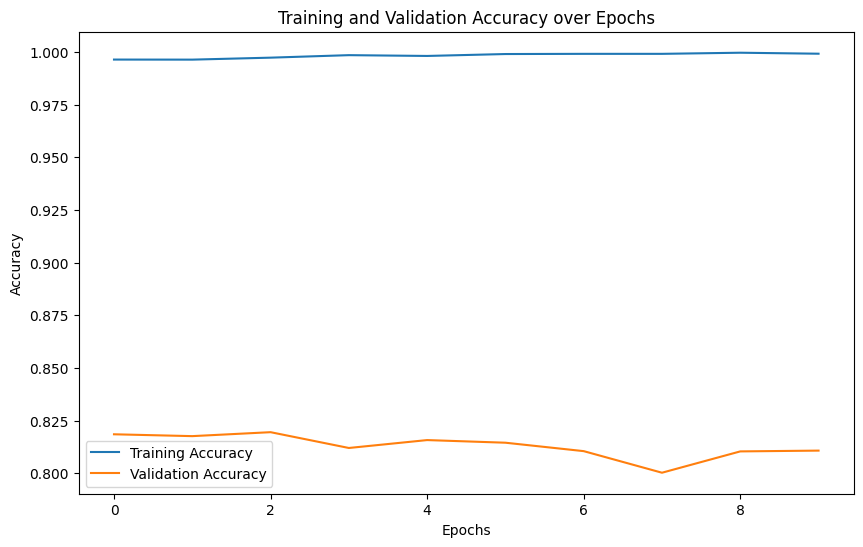

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
perdida, exactitud = modelo.evaluate([X_test_sequences, X_test_new_features], y_test,
                                     batch_size=32, verbose=2)
print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)


313/313 - 7s - loss: 1.7444 - accuracy: 0.8149 - 7s/epoch - 22ms/step
Pérdida de la Prueba: 1.7443960905075073
Exactitud de la Prueba (Test accuracy): 0.8148999810218811
